In [1]:
from qutipy.general_functions import *

In [2]:
import numpy as np 
import scipy.linalg
import math
#import import_ipynb 
import random
#from joblib  import Parallel, delayed 
import matplotlib.pyplot as plt
import time

In [14]:
mu = 1; N = 10; Jsq = 1; hc=1; dims = np.array([2]*N);

In [19]:
P_l = np.array([[0,0],[1,0]]);
P_r = np.array([[0,1],[0,0]]);
P_z = np.array([[1,0],[0,-1]]);
p_up = np.array([[1,0],[0,0]]); p_dw = np.array([[0,0],[0,1]]);
C = [];

In [20]:
print("Making Ci's")
C = []
ci = P_l;
for q in range(1,N):
    ci = np.kron(ci,np.identity(2)); 
C.append(ci);

for i in range(1,N): #Jordan Wigner transform
    ci = P_z;
    for q in range(1,i):
        ci = np.kron(ci,P_z);
    ci = np.kron(ci,P_l);
    for q in range(i,N-1):
        ci = np.kron(ci,np.identity(2)); 
    C.append(ci);

Making Ci's


In [17]:
# making a random J
print("Making J")
J_temp = np.random.normal(0,Jsq,[N,N,N,N]);
J_sym = 0.5*(J_temp + J_temp.transpose([2,3,0,1]));
J_1 = 0.5*(J_sym - J_sym.transpose([1,0,2,3])); J = 0.5*(J_1 - J_1.transpose([0,1,3,2]));

Making J


In [39]:
#THIS IS INCORRECT
"""
start = time.perf_counter()
H = np.zeros([2**N, 2**N]);
print("Making H")
for i in range(N): #instantiating Hamiltonian 
    print("Outer loop counter:", i)
    for j in range(N):
        print("Inner loop counter:", j)
        for k in range(N):
            for l in range(N):
                H = H + J[i,j,k,l]*np.transpose(C[i])*np.transpose(C[j])*C[k]*C[l]
    H *= (2*N)**(-1.5)
    H = H - mu*(np.transpose(C[i])*C[i]);
end = time.perf_counter()
execution_time = (end - start)
execution_time
"""

Making H
Outer loop counter: 0
Outer loop counter: 1
Outer loop counter: 2
Outer loop counter: 3
Outer loop counter: 4
Outer loop counter: 5
Outer loop counter: 6
Outer loop counter: 7
Outer loop counter: 8
Outer loop counter: 9


209.11898159096017

In [21]:
start = time.perf_counter()

H = np.zeros([2**N, 2**N]);
print("Making H")
for i in range(N): #instantiating Hamiltonian 
    print("Outer loop counter:", i)
    for j in range(N):
        #print("Inner loop counter:", j)
        temp = np.transpose(C[i]) @ np.transpose(C[j])
        for k in range(N):
            temp = temp @C[j]
            for l in range(N):
                H = H + J[i,j,k,l]*(temp @ C[l])
    H *= (2*N)**(-1.5)
    H = H - mu*(np.transpose(C[i]) @ C[i]);
                                    
end = time.perf_counter()
execution_time = (end - start)
execution_time

Making H
Outer loop counter: 0
Outer loop counter: 1
Outer loop counter: 2
Outer loop counter: 3
Outer loop counter: 4
Outer loop counter: 5
Outer loop counter: 6
Outer loop counter: 7
Outer loop counter: 8
Outer loop counter: 9


174.35289894603193

In [4]:
# Dump data to file

import hickle as hkl

data = {'ham': H}
hkl.dump( data, 'ham10.hkl' )

NameError: name 'H' is not defined

In [140]:
# loading data
import hickle as hkl
data = hkl.load('ham12.hkl')
H = data['ham']

In [116]:
H.shape

(4096, 4096)

Now to do measurements.

In [27]:
p_up = np.asarray([[1,0], [0,0]])
p_down = np.asarray([[0,0], [0,1]])
#P = [p_up, p_down]

In [141]:
p_up_array = []
for i in range(N):
    if i == 0:
        temp = p_up
    else:
        temp = np.eye(2)
    for j in range(1,N):
        if j == i:
            temp = np.kron(temp, p_up)
        else:
            temp = np.kron(temp, np.eye(2))
    p_up_array.append(temp)

In [35]:
down_up = [np.asarray([[0],[1]]), np.asarray([[1],[0]])]

In [152]:
from qutip import basis, tensor, Qobj, mesolve

"""psi_list = []
psi_list.append(basis(2,1))
for n in range(N-1):
    psi_list.append((1/np.sqrt(2))*(basis(2,0)+basis(2,1)))
psi0 = tensor(psi_list)"""

"""psi_list = []
psi_list.append(basis(2,0))
psi_list.append(basis(2,1))
for n in range(N-2):
    psi_list.append(basis(2,0))
psi0 = tensor(psi_list)"""

psi = np.zeros(2**N)
psi[1] = 1
psi0 = Qobj(psi, dims = [[2]*N,[1]*N ])

tlist = np.linspace(0, 30, 200)

qH = Qobj(H)
temp = np.array([2]*N)
qH.dims = [temp, temp]

states = []

p = 0.2 #measure all particles with probability p

start = time.perf_counter()
psi = psi0
for i in range(1,len(tlist)):
    print(i)
    times = [tlist[i-1], tlist[i]]
    #evolve for one timestep
    psi = mesolve(qH, psi, times).states[1].data.toarray()
    states.append(psi)
    rho = psi @ dag(psi)
    #perform probabilistic projective measurement
    if np.random.rand() <= p:
        measure_array = [1]*N #zero means project up, one means project down
        #rho_prob = np.zeros(N)
        for j in range(N):
            j_up = np.trace(p_up_array[j]*rho*p_up_array[j])
            if np.random.rand() <= j_up: #store in measure_array
                measure_array[j] = 0
        #now we create the appropriate product pure state
        #psi = down_up[measure_array[0]]
        psi = basis(2, measure_array[0])
        for j in range(1,N):
            #psi = np.kron(psi, down_up[measure_array[j]])
            psi = tensor(psi, basis(2, measure_array[j]))
    #psi = Qobj(psi, dims = [np.array([2]*N), np.array([1]*N)] )
    else:
        psi = Qobj(psi, dims = [[2]*N, [1]*N])
    
end = time.perf_counter()

execution_time = (end - start)
execution_time



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


102.07407381432131

In [88]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [130]:
np.where(np.real(states[1]) > 0.1)

(array([1024]), array([0]))

In [16]:
state = psi0.data
state = state.data.toarray()
state = state @ dag(state)
#rho = state
rho = partial_trace(state, [1,2,3,4,5], [2,2,2,2,2,2,2,2,2,2])

In [80]:
from scipy.linalg import logm

In [153]:
entropies = []
for i in range(len(tlist)-1):
    #print(i)
    psi = states[i]
    #psi = psi.toarray()
    rho = psi @ dag(psi)
    rho = partial_trace(rho, [1,2,3,4,5,6], [2,2,2,2,2,2,2,2,2,2,2,2])
    entropy = -np.real(Tr(rho@logm(rho)))/np.log(2)
    entropies.append(entropy)
    print(entropy)

0.00012657095563348847
0.00012657073706667048
0.0004494757391555872
0.00012657047406933376
0.00012657037860477557
0.0004494750872186977
0.0009319188908102788
0.001548779192995791
0.00227768201678951
0.003097125389016771
0.003985906389425408
0.004922996973197951
0.0001265699002419326
0.0004494742229858752
0.0009319176769363673
0.00012656977954167374
0.0004494740056236192
0.0009319173725766307
0.00012656967459984307
0.00044947381681628603
0.0009319171084414126
0.0015487769438754986
0.00012656955230364578
0.0004494735969742005
0.0009319168011404554
0.0015487765574941806
0.002277678888755872
0.003097121824532621
0.0039859024481861535
0.00012656937184799092
0.00044947327290273663
0.0009319163485841435
0.0015487759890178512
0.002277678216715412
0.0030971210617580357
0.00398590160816986
0.004922991815296993
0.0058876079107522
0.00685937249562506
0.0078185213747333
0.008746129187604345
0.009624338360228548
0.010436581395604994
0.011167789721181865
0.011804584325232747
0.012335444767776694
0.00

In [147]:
import matplotlib.pyplot as plt
%matplotlib inline

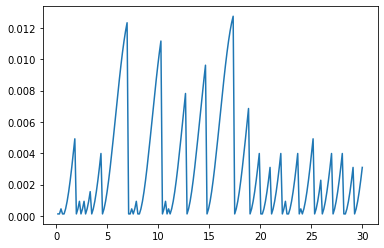

In [154]:
plt.plot(tlist[1:], entropies)

In [83]:
for i in range(len(tlist)-1):
    #print(i)
    psi = states[i]
    #psi = psi.toarray()
    rho = psi @ dag(psi)
    rho = partial_trace(rho, [1,2,3,4,5], [2,2,2,2,2,2,2,2,2,2])
    entropy = np.real(Tr(rho@logm(rho)))/np.log(2)
    print(entropy)

-5.8506880195905615e-05
-1.4220958815524933e-08
-1.4220962146627655e-08
-1.4220965784165673e-08
-1.4220967321663629e-08


/home/vkatariya/venv/lib/python3.6/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:829: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)


-1.4220969639969737e-08
-1.4220972349891577e-08
-1.4220973587376007e-08
-1.4220974512963032e-08
-1.4220976115693849e-08
-1.422097681456739e-08
-1.4220979508447253e-08
-1.4220979404513502e-08
-1.4220980677036805e-08
-1.4220980450890741e-08
-1.4220982576733366e-08
-1.4220984016765103e-08
-1.4220983814554076e-08
-1.422098437658288e-08
-1.4220985866381306e-08
-1.4220986685142577e-08
-1.422098619471444e-08
-1.4220988081259111e-08
-1.4220987541596921e-08
-1.4220989382606225e-08
-1.4220989281210659e-08
-1.4220990121881863e-08
-1.4220991105010543e-08
-1.4220991110523173e-08
-1.4220990780124857e-08
-1.4220991396113291e-08
-1.4220992959332959e-08
-1.4220993548500885e-08
-1.4220993164325669e-08
-1.422099421002771e-08
-1.422099380312322e-08
-1.4220995147593061e-08
-1.4220995200695024e-08
-1.4220995244274222e-08
-1.422099607962988e-08
-1.422099594528889e-08
-1.42209967636913e-08
-1.4220996933481015e-08
-1.4220997416022513e-08
-1.4220998211628786e-08
-1.4220998039225662e-08
-1.4220997219431336e-08
-

IndexError: list index out of range

In [42]:
a = state.toarray()

In [44]:
dag(a)

TypeError: Input is not a quantum object